In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import cv2

2025-12-16 17:00:17.902685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765904417.925987     175 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765904417.933075     175 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Parameters

In [2]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
NUM_CLASSES = 3
BATCH_SIZE = 8
EPOCHS = 30
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

# Model path
checkpoint_path = '/kaggle/working/segformer.pth'

# Dataloader

In [3]:
from albumentations import (
    Compose,
    RandomRotate90,
    Transpose,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomBrightnessContrast,
    HorizontalFlip,
    VerticalFlip,
    RandomGamma,
    RGBShift,
)

# Augmentation (no normalization/ToTensor here - handled in dataset)
augmentation = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomGamma(gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
])


/tmp/ipykernel_175/2677939484.py:19: UserWarning: Argument(s) 'eps, always_apply' are not valid for transform RandomGamma
  RandomGamma(gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


In [4]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)
        
        # Normalization for pretrained models
        self.normalize = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize, interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Red mask for neoplastic (class 1)
        lower_red1 = np.array([0, 100, 20])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 20])
        upper_red2 = np.array([179, 255, 255])
        
        lower_mask_red = cv2.inRange(image, lower_red1, upper_red1)
        upper_mask_red = cv2.inRange(image, lower_red2, upper_red2)
        
        red_mask = lower_mask_red + upper_mask_red
        red_mask[red_mask != 0] = 1

        # Green mask for non-neoplastic (class 2)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask  # Shape: (H, W), values: 0, 1, 2

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        
        # Load and resize image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.resize, interpolation=cv2.INTER_AREA)
        
        # Load mask
        label = self.read_mask(label_path)
        
        # Apply augmentation if provided
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed["image"]
            label = transformed["mask"]
        
        # Normalize and convert to tensor
        normalized = self.normalize(image=image, mask=label)
        image = normalized["image"]  # torch.FloatTensor (C, H, W)
        label = normalized["mask"].long()  # torch.LongTensor (H, W)
            
        return image, label
    
class TestDataset(Dataset):
    def __init__(self, img_dir="path/to/data", resize=None, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.resize = resize
        self.images = os.listdir(self.img_dir)
        
        # Normalization for pretrained models
        self.normalize = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        image = cv2.resize(image, self.resize, interpolation=cv2.INTER_AREA)
        name = os.path.basename(img_path).split('.')[0]
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        
        # Normalize and convert to tensor
        normalized = self.normalize(image=image)
        image = normalized["image"]  # torch.FloatTensor (C, H, W)
        
        return image, height, width, name


In [5]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"
test_images_path = "/kaggle/input/bkai-igh-neopolyp/test/test/"

In [6]:
dataset = TrainDataset(images_path, masks_path, resize=(512, 512), transform=augmentation)

Dataset Diagnostics
Dataset size: 1000

Sample 0:
  Image shape: torch.Size([3, 512, 512]), dtype: torch.float32
  Mask shape: torch.Size([512, 512]), dtype: torch.int64
  Mask unique values: [0 1]
  Mask min: 0, max: 1
  ✓ Mask values are valid (0 to 2)

Sample 1:
  Image shape: torch.Size([3, 512, 512]), dtype: torch.float32
  Mask shape: torch.Size([512, 512]), dtype: torch.int64
  Mask unique values: [0 1]
  Mask min: 0, max: 1
  ✓ Mask values are valid (0 to 2)

Sample 2:
  Image shape: torch.Size([3, 512, 512]), dtype: torch.float32
  Mask shape: torch.Size([512, 512]), dtype: torch.int64
  Mask unique values: [0 1]
  Mask min: 0, max: 1
  ✓ Mask values are valid (0 to 2)

Sample 3:
  Image shape: torch.Size([3, 512, 512]), dtype: torch.float32
  Mask shape: torch.Size([512, 512]), dtype: torch.int64
  Mask unique values: [0 1]
  Mask min: 0, max: 1
  ✓ Mask values are valid (0 to 2)

Sample 4:
  Image shape: torch.Size([3, 512, 512]), dtype: torch.float32
  Mask shape: torch.Siz

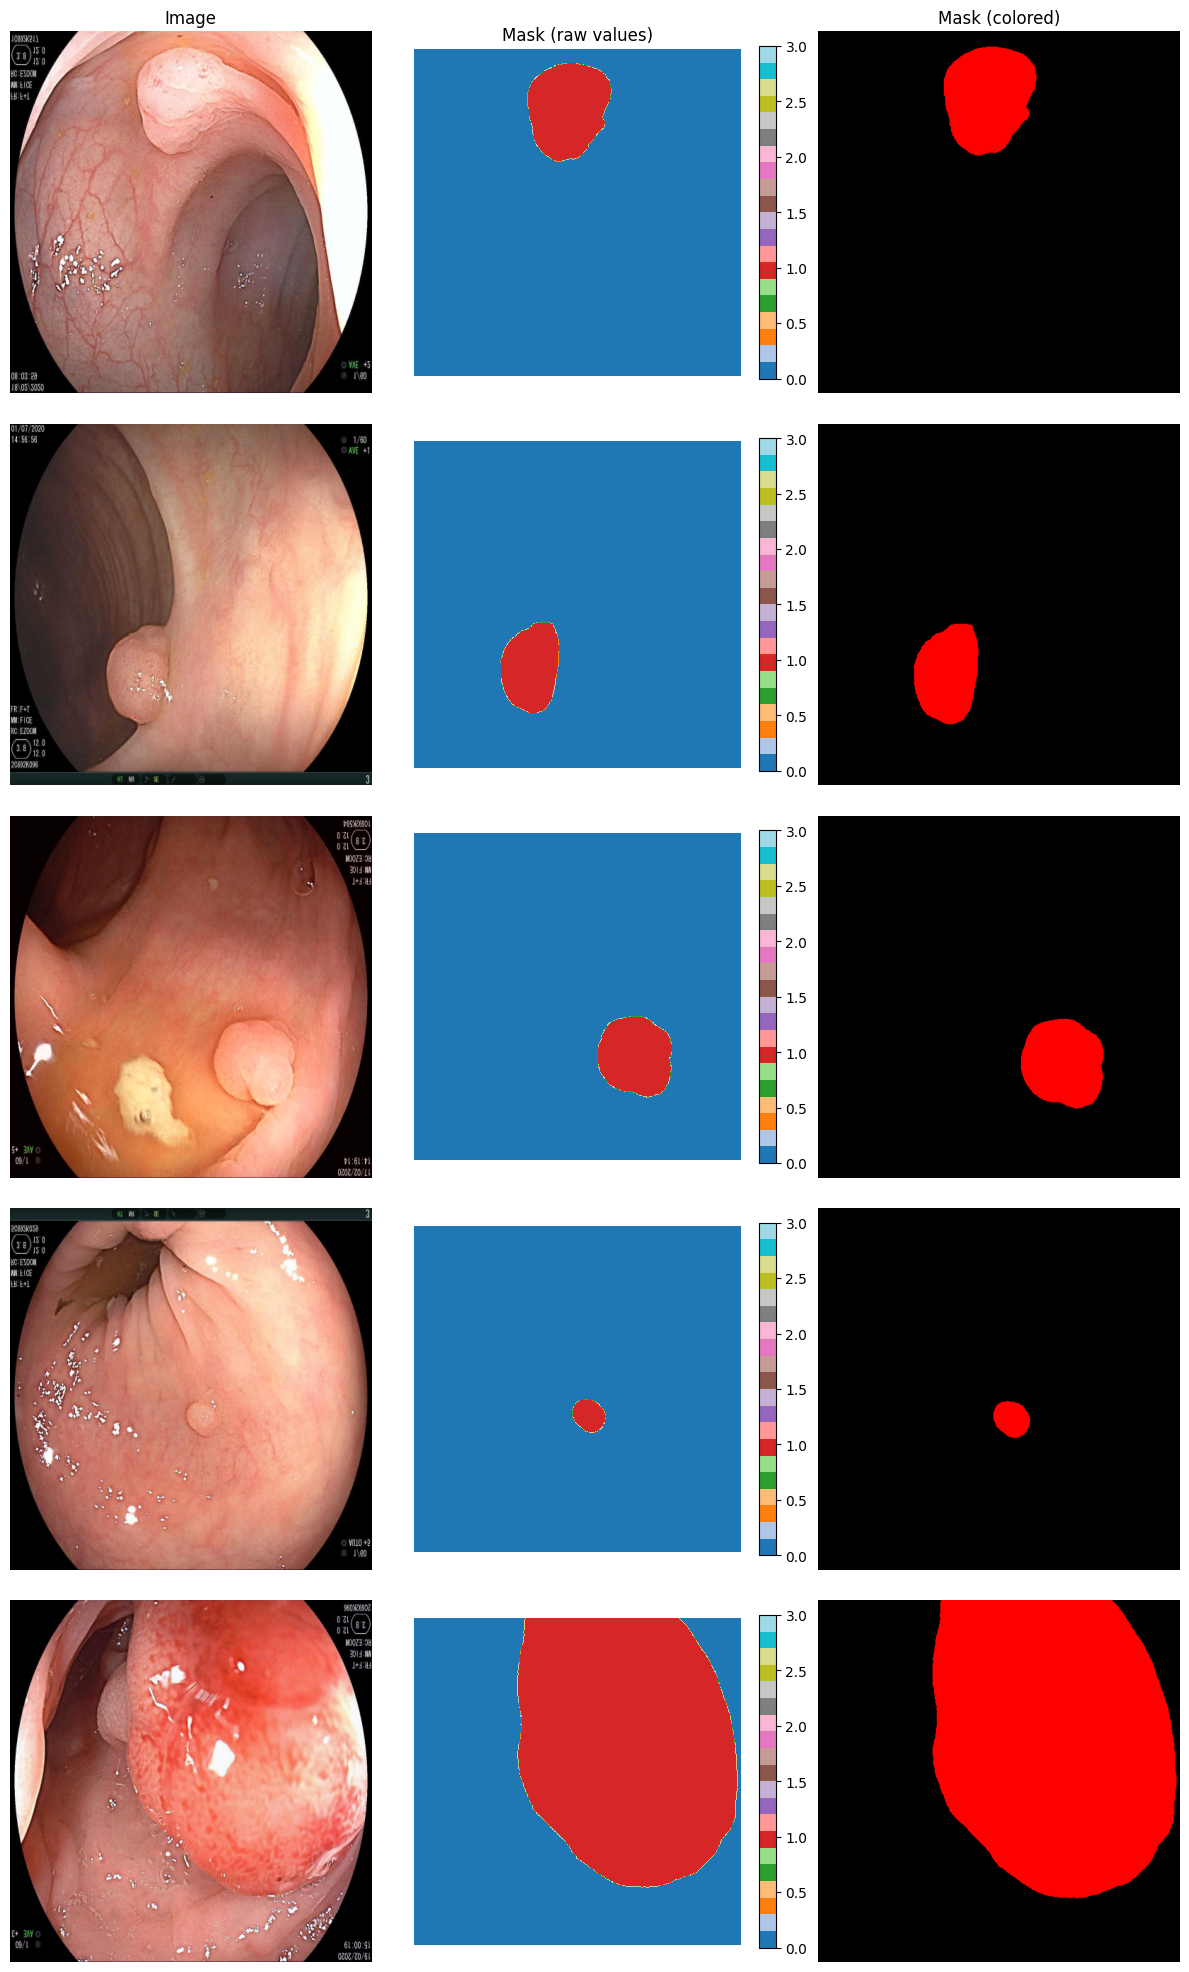


Dataset is ready for training!


In [7]:
# Visualize dataset samples and check label values
import matplotlib.pyplot as plt

def denormalize(img_tensor):
    """Denormalize image for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)

# Check a few samples from the dataset
print("=" * 60)
print("Dataset Diagnostics")
print("=" * 60)
print(f"Dataset size: {len(dataset)}")

# Check first 5 samples
fig, axes = plt.subplots(5, 3, figsize=(12, 20))
axes[0, 0].set_title('Image', fontsize=12)
axes[0, 1].set_title('Mask (raw values)', fontsize=12)
axes[0, 2].set_title('Mask (colored)', fontsize=12)

# Color map for visualization
colors = np.array([
    [0, 0, 0],       # 0: Background - black
    [255, 0, 0],     # 1: Neoplastic - red  
    [0, 255, 0],     # 2: Non-neoplastic - green
], dtype=np.uint8)

def mask_to_rgb_viz(mask):
    """Convert class mask to RGB, handle out-of-range values"""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for c in range(min(len(colors), mask.max() + 1)):
        rgb[mask == c] = colors[c] if c < len(colors) else [128, 128, 128]
    # Mark out-of-range values in yellow
    rgb[mask >= len(colors)] = [255, 255, 0]
    return rgb

for i in range(min(5, len(dataset))):
    img, mask = dataset[i]
    
    # Now img is a tensor and mask is a tensor
    unique_vals = torch.unique(mask).numpy()
    print(f"\nSample {i}:")
    print(f"  Image shape: {img.shape}, dtype: {img.dtype}")
    print(f"  Mask shape: {mask.shape}, dtype: {mask.dtype}")
    print(f"  Mask unique values: {unique_vals}")
    print(f"  Mask min: {mask.min().item()}, max: {mask.max().item()}")
    
    if mask.max() >= NUM_CLASSES:
        print(f"  ⚠️ WARNING: Mask contains values >= NUM_CLASSES ({NUM_CLASSES})")
    else:
        print(f"  ✓ Mask values are valid (0 to {NUM_CLASSES-1})")
    
    # Display
    img_display = denormalize(img).permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    
    axes[i, 0].imshow(img_display)
    axes[i, 0].axis('off')
    
    # Show raw mask values
    im = axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=max(3, mask_np.max()))
    axes[i, 1].axis('off')
    plt.colorbar(im, ax=axes[i, 1], fraction=0.046)
    
    # Show colored mask
    axes[i, 2].imshow(mask_to_rgb_viz(mask_np))
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Dataset is ready for training!")
print("=" * 60)


In [8]:
torch.manual_seed(42)

In [9]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)

# Model

In [11]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b3",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
).to(DEVICE)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# CE + Dice Loss for semantic segmentation
import torch.nn as nn

def one_hot(labels, num_classes, device, dtype):
    """Convert labels (B, H, W) to one-hot (B, C, H, W)"""
    shape = labels.shape
    one_hot = torch.zeros(shape[0], num_classes, *shape[1:], device=device, dtype=dtype)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

class DiceLoss(nn.Module):
    """Dice Loss for multi-class segmentation"""
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    
    def forward(self, input, target):
        # input: (B, C, H, W) logits
        # target: (B, H, W) class indices
        num_classes = input.shape[1]
        input_soft = F.softmax(input, dim=1)
        target_one_hot = one_hot(target, num_classes, input.device, input.dtype)
        
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)
        
        dice_score = 2.0 * intersection / (cardinality + self.eps)
        return 1.0 - dice_score.mean()

class CEDiceLoss(nn.Module):
    """Combined Cross-Entropy and Dice Loss"""
    def __init__(self, ce_weight=0.5, dice_weight=0.5, class_weights=None):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.dice_loss = DiceLoss()
    
    def forward(self, input, target):
        ce = self.ce_loss(input, target)
        dice = self.dice_loss(input, target)
        return self.ce_weight * ce + self.dice_weight * dice

# Initialize loss and optimizer
class_weights = torch.tensor([0.2, 0.4, 0.4]).to(DEVICE)  # background, neoplastic, non-neoplastic
loss_function = CEDiceLoss(ce_weight=0.5, dice_weight=0.5, class_weights=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


**Train model**

In [13]:
# Training loop with validation and Dice evaluation
import time
import matplotlib.pyplot as plt

def calculate_dice_per_class(preds, targets, num_classes, eps=1e-6):
    """Calculate Dice score per class"""
    dice_scores = []
    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice = (2.0 * intersection + eps) / (union + eps)
        dice_scores.append(dice.item())
    return dice_scores

best_val_dice = 0.0
train_losses = []
val_losses = []
val_dices = []

for epoch in range(EPOCHS):
    t0 = time.time()
    
    # ===== Training =====
    model.train()
    train_loss = 0.0
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Train"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(pixel_values=x)
        logits = outputs.logits  # (B, C, h, w)
        
        # Upsample logits to target size
        logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        loss = loss_function(logits, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # ===== Validation =====
    model.eval()
    val_loss = 0.0
    all_dice_scores = [[] for _ in range(NUM_CLASSES)]
    
    with torch.no_grad():
        for x_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Val"):
            x_val = x_val.to(DEVICE)
            y_val = y_val.to(DEVICE)
            
            logits_val = model(pixel_values=x_val).logits
            logits_val = F.interpolate(logits_val, size=y_val.shape[-2:], mode='bilinear', align_corners=False)
            
            loss_v = loss_function(logits_val, y_val)
            val_loss += loss_v.item()
            
            preds = torch.argmax(logits_val, dim=1)
            dice_scores = calculate_dice_per_class(preds, y_val, NUM_CLASSES)
            for c in range(NUM_CLASSES):
                all_dice_scores[c].append(dice_scores[c])
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Calculate mean Dice per class
    mean_dice_per_class = [np.mean(scores) for scores in all_dice_scores]
    mean_dice = np.mean(mean_dice_per_class)
    val_dices.append(mean_dice)
    
    scheduler.step()
    elapsed = time.time() - t0
    
    print(f"\nEpoch {epoch+1}/{EPOCHS} ({elapsed:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice - Background: {mean_dice_per_class[0]:.4f}, Neoplastic: {mean_dice_per_class[1]:.4f}, Non-neoplastic: {mean_dice_per_class[2]:.4f}")
    print(f"  Mean Dice: {mean_dice:.4f}")
    
    # Save best model
    if mean_dice > best_val_dice:
        best_val_dice = mean_dice
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': mean_dice,
        }, checkpoint_path)
        print(f"  ✓ Saved best model (Dice: {mean_dice:.4f})")

print(f"\n Training complete! Best Val Dice: {best_val_dice:.4f}")


Epoch 1/30 - Val: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]



Epoch 1/30 (331.0s)
  Train Loss: 0.3617
  Val Loss: 0.2643
  Dice - Background: 0.9919, Neoplastic: 0.7067, Non-neoplastic: 0.5877
  Mean Dice: 0.7621
  ✓ Saved best model (Dice: 0.7621)


Epoch 2/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]



Epoch 2/30 (322.0s)
  Train Loss: 0.2494
  Val Loss: 0.2378
  Dice - Background: 0.9945, Neoplastic: 0.7370, Non-neoplastic: 0.7213
  Mean Dice: 0.8176
  ✓ Saved best model (Dice: 0.8176)


Epoch 3/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.30it/s]



Epoch 3/30 (321.7s)
  Train Loss: 0.2316
  Val Loss: 0.2338
  Dice - Background: 0.9943, Neoplastic: 0.7636, Non-neoplastic: 0.5442
  Mean Dice: 0.7674


Epoch 4/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.32it/s]



Epoch 4/30 (321.3s)
  Train Loss: 0.2169
  Val Loss: 0.2339
  Dice - Background: 0.9932, Neoplastic: 0.7997, Non-neoplastic: 0.4921
  Mean Dice: 0.7617


Epoch 5/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]



Epoch 5/30 (321.6s)
  Train Loss: 0.2067
  Val Loss: 0.2196
  Dice - Background: 0.9956, Neoplastic: 0.8173, Non-neoplastic: 0.6292
  Mean Dice: 0.8141


Epoch 6/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.48it/s]



Epoch 6/30 (320.3s)
  Train Loss: 0.1969
  Val Loss: 0.2209
  Dice - Background: 0.9950, Neoplastic: 0.8586, Non-neoplastic: 0.7039
  Mean Dice: 0.8525
  ✓ Saved best model (Dice: 0.8525)


Epoch 7/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]



Epoch 7/30 (320.9s)
  Train Loss: 0.1960
  Val Loss: 0.2148
  Dice - Background: 0.9962, Neoplastic: 0.8487, Non-neoplastic: 0.8074
  Mean Dice: 0.8841
  ✓ Saved best model (Dice: 0.8841)


Epoch 8/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]



Epoch 8/30 (322.0s)
  Train Loss: 0.1892
  Val Loss: 0.2205
  Dice - Background: 0.9965, Neoplastic: 0.8211, Non-neoplastic: 0.8546
  Mean Dice: 0.8907
  ✓ Saved best model (Dice: 0.8907)


Epoch 9/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]



Epoch 9/30 (322.0s)
  Train Loss: 0.1879
  Val Loss: 0.2238
  Dice - Background: 0.9962, Neoplastic: 0.8570, Non-neoplastic: 0.7311
  Mean Dice: 0.8615


Epoch 10/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]



Epoch 10/30 (322.0s)
  Train Loss: 0.1827
  Val Loss: 0.2159
  Dice - Background: 0.9963, Neoplastic: 0.8565, Non-neoplastic: 0.8192
  Mean Dice: 0.8907


Epoch 11/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]



Epoch 11/30 (321.3s)
  Train Loss: 0.1823
  Val Loss: 0.2157
  Dice - Background: 0.9962, Neoplastic: 0.8620, Non-neoplastic: 0.8688
  Mean Dice: 0.9090
  ✓ Saved best model (Dice: 0.9090)


Epoch 12/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]



Epoch 12/30 (322.0s)
  Train Loss: 0.1782
  Val Loss: 0.2085
  Dice - Background: 0.9969, Neoplastic: 0.8575, Non-neoplastic: 0.8646
  Mean Dice: 0.9063


Epoch 13/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]



Epoch 13/30 (322.4s)
  Train Loss: 0.1767
  Val Loss: 0.2084
  Dice - Background: 0.9965, Neoplastic: 0.8802, Non-neoplastic: 0.8254
  Mean Dice: 0.9007


Epoch 14/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]



Epoch 14/30 (322.6s)
  Train Loss: 0.1762
  Val Loss: 0.2193
  Dice - Background: 0.9965, Neoplastic: 0.8417, Non-neoplastic: 0.8400
  Mean Dice: 0.8927


Epoch 15/30 - Train:  17%|█▋        | 19/113 [00:53<04:22,  2.79s/it]Exception ignored in: <function _xla_gc_callback at 0x799191378680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Epoch 15/30 - Val: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]



Epoch 15/30 (322.6s)
  Train Loss: 0.1746
  Val Loss: 0.2103
  Dice - Background: 0.9966, Neoplastic: 0.8835, Non-neoplastic: 0.8476
  Mean Dice: 0.9092
  ✓ Saved best model (Dice: 0.9092)


Epoch 16/30 - Train:   4%|▎         | 4/113 [00:13<06:20,  3.49s/it]


KeyboardInterrupt: 

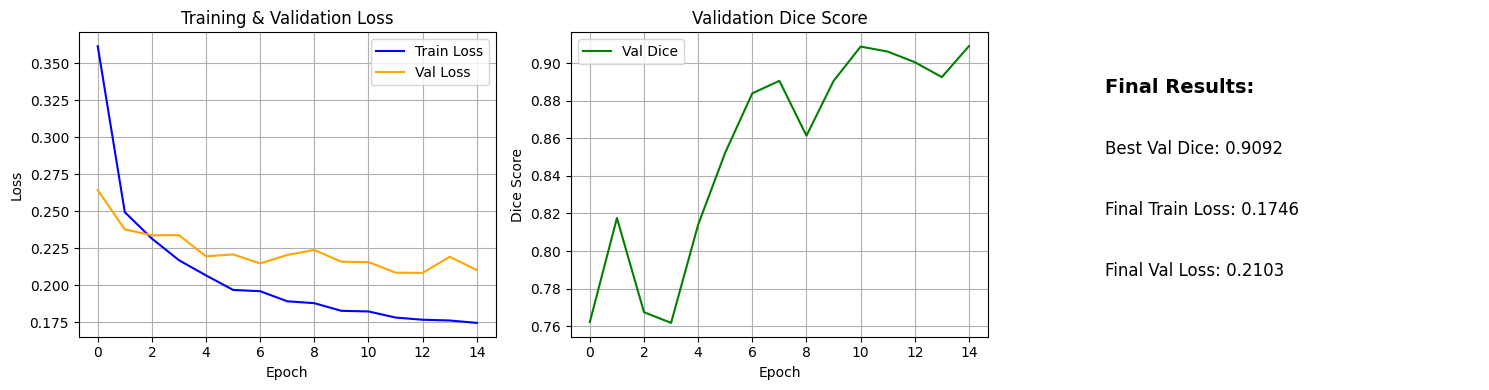

In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Dice curve
axes[1].plot(val_dices, label='Val Dice', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Validation Dice Score')
axes[1].legend()
axes[1].grid(True)

# Final metrics
axes[2].axis('off')
axes[2].text(0.1, 0.8, f"Final Results:", fontsize=14, fontweight='bold')
axes[2].text(0.1, 0.6, f"Best Val Dice: {best_val_dice:.4f}", fontsize=12)
axes[2].text(0.1, 0.4, f"Final Train Loss: {train_losses[-1]:.4f}", fontsize=12)
axes[2].text(0.1, 0.2, f"Final Val Loss: {val_losses[-1]:.4f}", fontsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png', dpi=150)
plt.show()


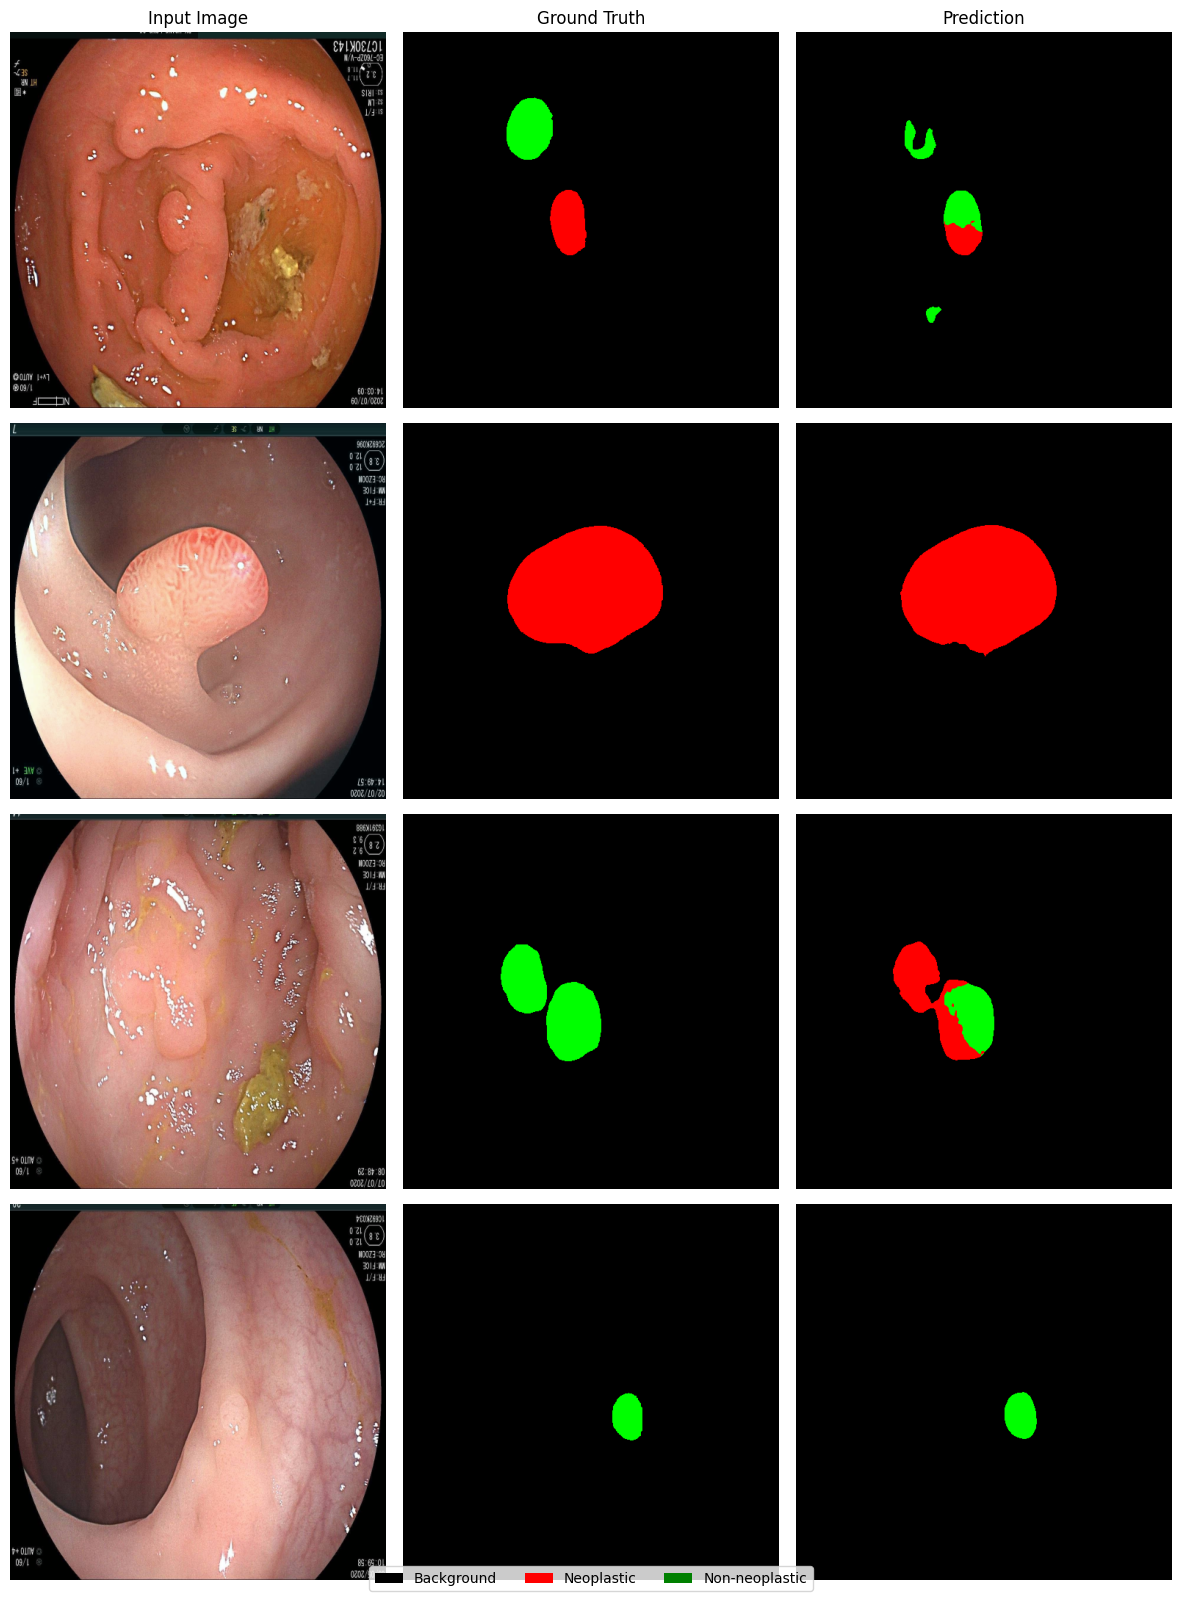

In [15]:
# Visualize sample predictions on validation set
def denormalize(img_tensor):
    """Denormalize image for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor.cpu() * std + mean).clamp(0, 1)

# Color map for 3 classes: background (black), neoplastic (red), non-neoplastic (green)
colors = np.array([
    [0, 0, 0],       # Background - black
    [255, 0, 0],     # Neoplastic - red  
    [0, 255, 0],     # Non-neoplastic - green
], dtype=np.uint8)

def mask_to_rgb(mask):
    """Convert class mask to RGB image"""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for c in range(len(colors)):
        rgb[mask == c] = colors[c]
    return rgb

# Get some validation samples
model.eval()
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
axes[0, 0].set_title('Input Image', fontsize=12)
axes[0, 1].set_title('Ground Truth', fontsize=12)
axes[0, 2].set_title('Prediction', fontsize=12)

val_iter = iter(val_loader)
for i in range(4):
    try:
        x_val, y_val = next(val_iter)
    except StopIteration:
        break
    
    x_val = x_val.to(DEVICE)
    with torch.no_grad():
        logits = model(pixel_values=x_val).logits
        logits = F.interpolate(logits, size=y_val.shape[-2:], mode='bilinear', align_corners=False)
        pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
    
    # Display
    img_display = denormalize(x_val[0]).permute(1, 2, 0).numpy()
    gt_display = mask_to_rgb(y_val[0].numpy())
    pred_display = mask_to_rgb(pred)
    
    axes[i, 0].imshow(img_display)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(gt_display)
    axes[i, 1].axis('off')
    axes[i, 2].imshow(pred_display)
    axes[i, 2].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='black', label='Background'),
    Patch(facecolor='red', label='Neoplastic'),
    Patch(facecolor='green', label='Non-neoplastic')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)

plt.tight_layout()
plt.savefig('/kaggle/working/validation_samples.png', dpi=150, bbox_inches='tight')
plt.show()


In [16]:
# Test Dataset for inference
from torchvision.transforms import Resize, ToPILImage, InterpolationMode
import cv2

class TestDataset(Dataset):
    def __init__(self, images_path):
        super().__init__()
        self.images_list = sorted([os.path.join(images_path, f) for f in os.listdir(images_path)])
        self.transform = A.Compose([
            A.Resize(512, 512),
            A.Normalize(),
            ToTensorV2()
        ])
    
    def __getitem__(self, index):
        img_path = self.images_list[index]
        img = Image.open(img_path).convert("RGB")
        original_size = (img.size[1], img.size[0])  # (H, W)
        transformed = self.transform(image=np.array(img))
        return transformed["image"], img_path, original_size[0], original_size[1]
    
    def __len__(self):
        return len(self.images_list)

# Create test dataloader
test_dataset = TestDataset(test_images_path)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 200


In [18]:
# Run inference on test set and save predictions
import os

# Load best model
checkpoint = torch.load(checkpoint_path, weights_only = False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model with Val Dice: {checkpoint['val_dice']:.4f}")

# Create output directory
output_dir = "/kaggle/working/predicted_masks"
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, paths, heights, widths) in enumerate(tqdm(test_dataloader, desc="Inference")):
        imgs = imgs.to(DEVICE)
        
        # Get predictions
        logits = model(pixel_values=imgs).logits
        
        # Process each image in batch
        for i in range(len(paths)):
            h, w = heights[i].item(), widths[i].item()
            
            # Upsample to original size
            logit = logits[i:i+1]
            logit = F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=False)
            pred = torch.argmax(logit, dim=1).squeeze().cpu().numpy().astype(np.uint8)
            
            # Convert to color mask for visualization
            pred_rgb = mask_to_rgb(pred)
            
            # Save prediction
            image_id = os.path.basename(paths[i]).split('.')[0]
            filename = f"{image_id}.png"
            
            # Save as PNG
            pred_img = Image.fromarray(pred_rgb)
            pred_img.save(os.path.join(output_dir, filename))

print(f"Saved {len(test_dataset)} predictions to {output_dir}")


Loaded model with Val Dice: 0.9092


Inference: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]

Saved 200 predictions to /kaggle/working/predicted_masks


In [19]:
# Create submission CSV with RLE encoding
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(mask_dir):
    """Convert masks to RLE strings for submission"""
    strings = []
    ids = []
    
    for image_id in sorted(os.listdir(mask_dir)):
        id_name = image_id.split('.')[0]
        path = os.path.join(mask_dir, image_id)
        img = cv2.imread(path)[:,:,::-1]  # BGR to RGB
        
        # Channel 0: neoplastic (red channel)
        # Channel 1: non-neoplastic (green channel)
        for channel in range(2):
            ids.append(f'{id_name}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    
    return {'ids': ids, 'strings': strings}

# Generate submission
MASK_DIR_PATH = '/kaggle/working/predicted_masks'
res = mask2string(MASK_DIR_PATH)

df = pd.DataFrame({
    'Id': res['ids'],
    'Expected': res['strings']
})
df.to_csv('/kaggle/working/submission.csv', index=False)
print(f"Submission saved with {len(df)} entries")
df.head(10)


Submission saved with 400 entries


Id  \
0  019410b1fcf0625f608b4ce97629ab55_0   
1  019410b1fcf0625f608b4ce97629ab55_1   
2  02fa602bb3c7abacdbd7e6afd56ea7bc_0   
3  02fa602bb3c7abacdbd7e6afd56ea7bc_1   
4  0398846f67b5df7cdf3f33c3ca4d5060_0   
5  0398846f67b5df7cdf3f33c3ca4d5060_1   
6  05734fbeedd0f9da760db74a29abdb04_0   
7  05734fbeedd0f9da760db74a29abdb04_1   
8  05b78a91391adc0bb223c4eaf3372eae_0   
9  05b78a91391adc0bb223c4eaf3372eae_1   

                                            Expected  
0  575333 10 576600 38 577874 50 579150 56 580427...  
1                                                     
2  579312 1 580591 5 581871 7 583116 3 583150 10 ...  
3  576729 17 578004 26 579282 30 580560 31 581838...  
4  431799 11 433072 25 434348 31 435625 35 436901...  
5                                                     
6  320619 28 321890 50 323163 65 324440 72 325719...  
7  478375 6 479651 18 480926 25 482204 30 483482 ...  
8                                                     
9  708613 16 709890 22 711167 28 712445 32 713723...

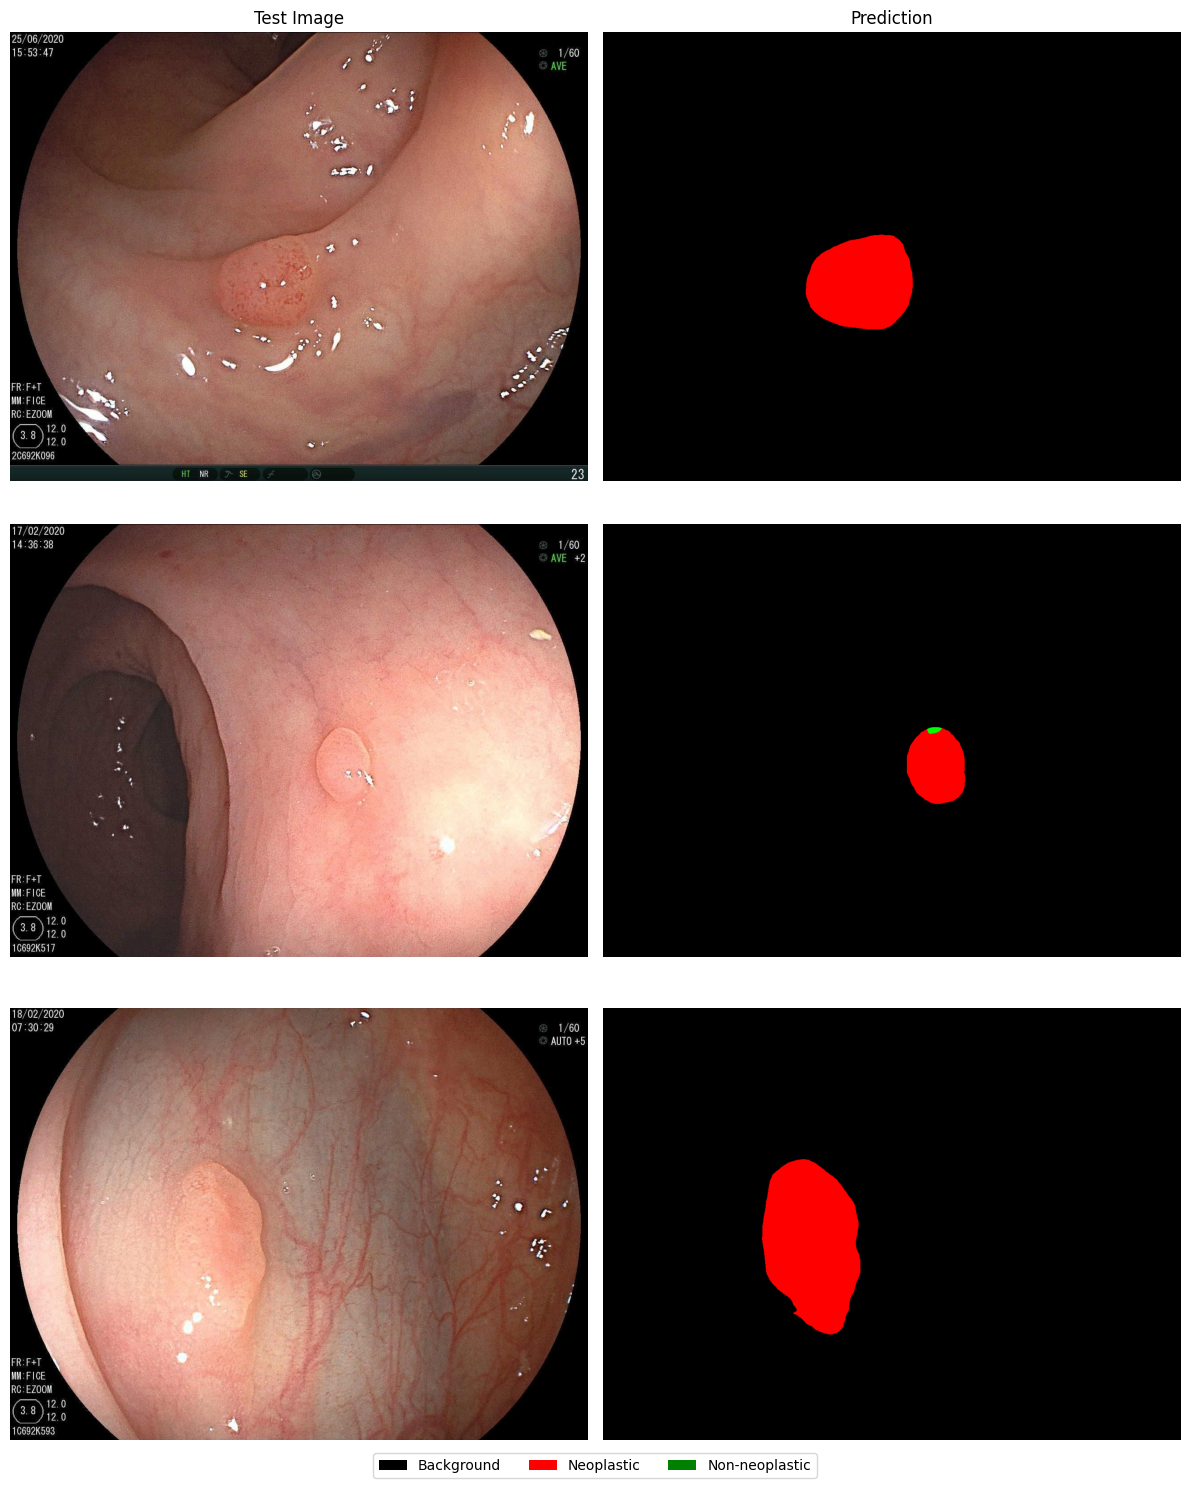

In [20]:
# Visualize some test predictions
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes[0, 0].set_title('Test Image', fontsize=12)
axes[0, 1].set_title('Prediction', fontsize=12)

test_iter = iter(test_dataloader)
imgs, paths, heights, widths = next(test_iter)
imgs = imgs.to(DEVICE)

model.eval()
with torch.no_grad():
    logits = model(pixel_values=imgs).logits

for i in range(min(3, len(imgs))):
    # Original image
    original_img = Image.open(paths[i]).convert("RGB")
    
    # Prediction
    h, w = heights[i].item(), widths[i].item()
    logit = logits[i:i+1]
    logit = F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=False)
    pred = torch.argmax(logit, dim=1).squeeze().cpu().numpy().astype(np.uint8)
    pred_rgb = mask_to_rgb(pred)
    
    axes[i, 0].imshow(original_img)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(pred_rgb)
    axes[i, 1].axis('off')

# Add legend
legend_elements = [
    Patch(facecolor='black', label='Background'),
    Patch(facecolor='red', label='Neoplastic'),
    Patch(facecolor='green', label='Non-neoplastic')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)

plt.tight_layout()
plt.savefig('/kaggle/working/test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
